In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys, glob, copy
#[sys.path.append(f) for f in glob.glob('../utils/*')]
from utils.plotting.plotting_utils import figSize
from utils.simulation import simulation_utils
from utils.preprocessing import sweep_utils


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl


# for a reproducible result
np.random.seed(1)

### Visualize hyperparameter searches for methods in simulator



593 files. Missing: []


/tmp/ipykernel_19001/1790790045.py:92: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = scores_subset, x = var, y = 'ttt', palette = palette, alpha = 0.6)
/tmp/ipykernel_19001/1790790045.py:92: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = scores_subset, x = var, y = 'ttt', palette = palette, alpha = 0.6)
/tmp/ipykernel_19001/1790790045.py:92: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = scores_subset, x = var, y = 'ttt', palette = palette, alpha = 0.6)


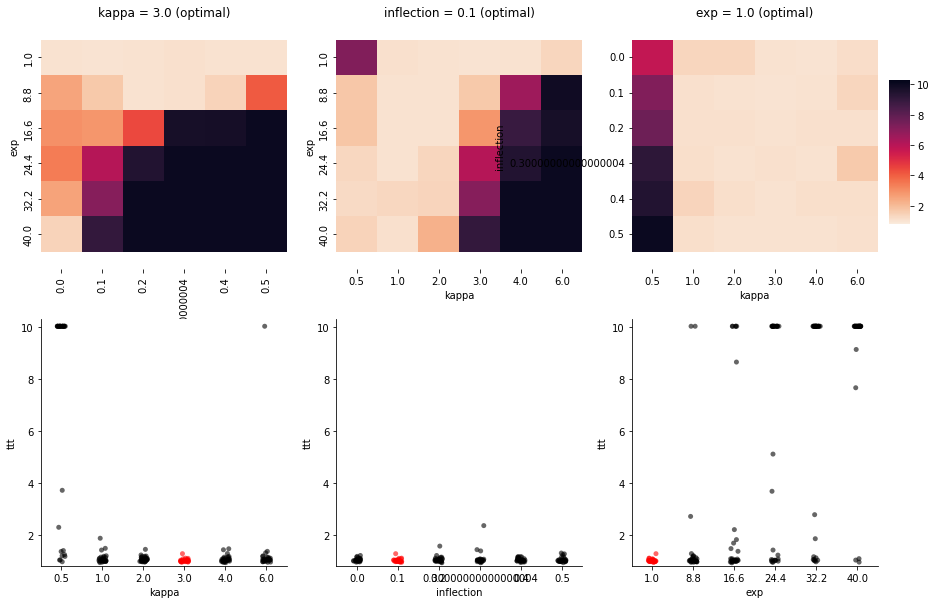

/tmp/ipykernel_19001/1790790045.py:92: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = scores_subset, x = var, y = 'ttt', palette = palette, alpha = 0.6)
/tmp/ipykernel_19001/1790790045.py:92: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = scores_subset, x = var, y = 'ttt', palette = palette, alpha = 0.6)
/tmp/ipykernel_19001/1790790045.py:92: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = scores_subset, x = var, y = 'ttt', palette = palette, alpha = 0.6)


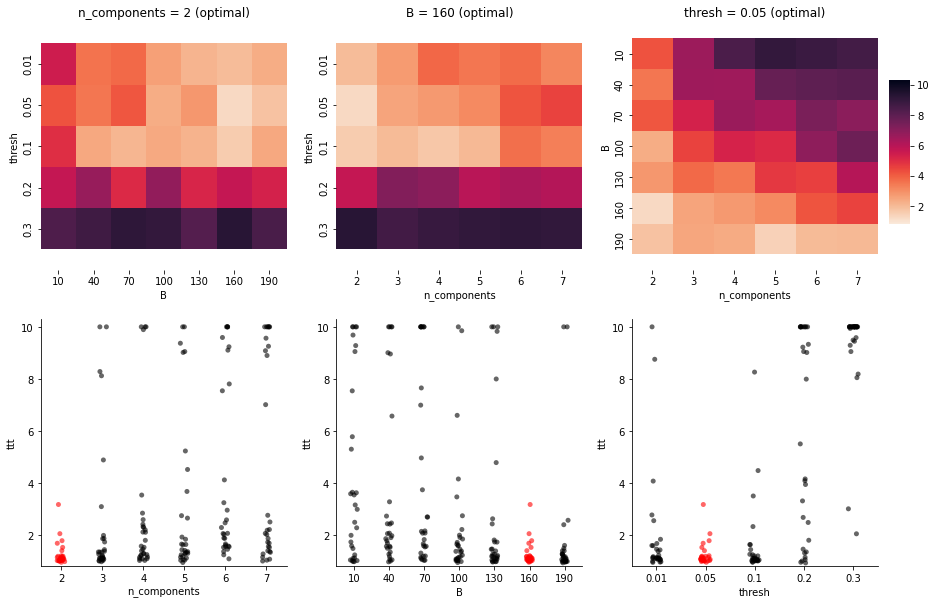

/tmp/ipykernel_19001/1790790045.py:92: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = scores_subset, x = var, y = 'ttt', palette = palette, alpha = 0.6)
/tmp/ipykernel_19001/1790790045.py:92: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = scores_subset, x = var, y = 'ttt', palette = palette, alpha = 0.6)
/tmp/ipykernel_19001/1790790045.py:92: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = scores_subset, x = var, y = 'ttt', palette = palette, alpha = 0.6)


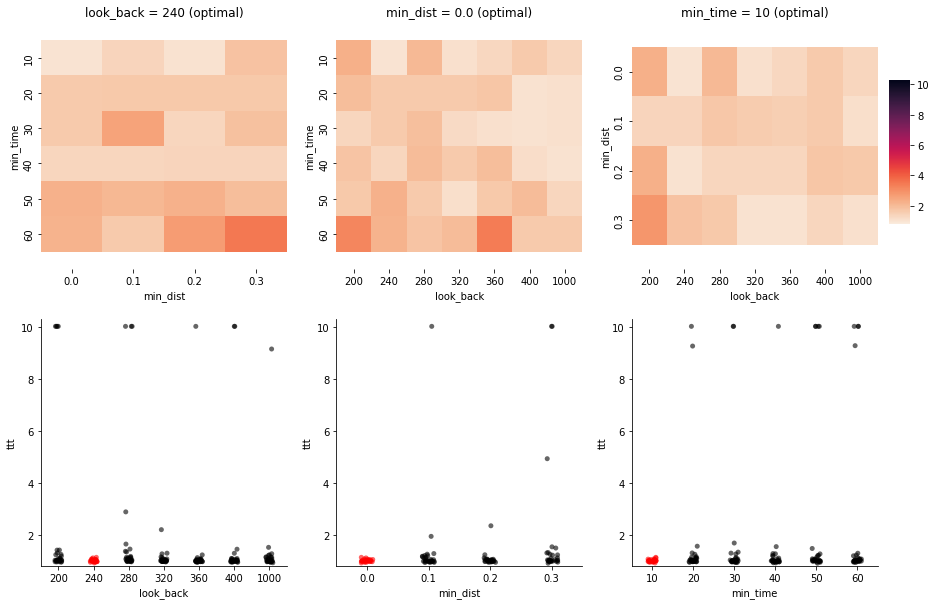

In [3]:
save_dir  = '/oak/stanford/groups/henderj/ghwilson/nonstationarities/simulator/pause_sweeps/'
save_dir  = '/oak/stanford/groups/henderj/ghwilson/nonstationarities/simulator/retargeting_sweeps/'

# where to save figure files to
fig_path = FIG_DIR

# y-axis limits for trial time plots
lims     = [0.8, 10.3]

# -------------------------------------------------------


files    = glob.glob(save_dir + '*')
IDs      = [int(x.split('scores_')[1].split('.npy')[0]) for x in files]
missing  = np.setdiff1d(np.arange(np.max(IDs) + 1), IDs)
print(np.max(IDs), 'files. Missing:', missing)

dicts = np.concatenate([np.load(x, allow_pickle = True) for x in files])

hmm_session_scores = pd.DataFrame([x for x in dicts if 'kappa' in x.keys()])
ss_session_scores  = pd.DataFrame([x for x in dicts if 'n_components' in x.keys()])
rti_session_scores = pd.DataFrame([x for x in dicts if 'look_back' in x.keys()])


sweep_keys = [['kappa', 'inflection', 'exp'],
              ['n_components', 'B', 'thresh'],
              ['look_back', 'min_dist', 'min_time']]

scores_dfs      = [hmm_session_scores, ss_session_scores, rti_session_scores]

# RTI only
#sweep_keys = [['look_back', 'min_dist', 'min_time']]
#scores_dfs      = [rti_session_scores]

sweep_opts_list = [dict(), dict(), dict()]

for keys, df, opts in zip(sweep_keys, scores_dfs, sweep_opts_list):
    for key in keys:
        opts[key] = np.unique(df[key])


for fignum, (sweep_opts, scores_dict) in enumerate(zip(sweep_opts_list, scores_dfs)):
    scores_df = pd.DataFrame(scores_dict)

    scores_df['median ttt'] = scores_df.apply(lambda row: np.mean(row.ttt), axis=1)
    opt_vals = np.argmin(scores_df['median ttt'])

    opt_dict = dict()
    for key in sweep_opts.keys():
        opt_dict[key] = scores_df.iloc[opt_vals][key]

    if 'look_back' in opt_dict.keys():
        method = 'RTI'
    elif 'kappa' in opt_dict.keys():
        method = 'PRI-T'
    elif 'n_components' in opt_dict.keys():
        method = 'FA_stabilizer'
    else:
        raise ValueError('Method not found')

    figSize(10, 15)
    fig = plt.figure(fignum)
    cbar_ax = fig.add_axes([.91, .6, .02, .2])

    for i, var in enumerate(sweep_opts.keys()):

        var_opt  = scores_df.iloc[opt_vals][var]
        opt_idx  = np.where(sweep_opts[var] == var_opt)[0][0]

        opt_copy = dict(opt_dict)
        opt_copy.pop(var)

        plt.subplot(2, 3, i + 1)

        in_df = scores_df[scores_df[var] == var_opt]
        df_m  = in_df.groupby([list(opt_copy.keys())[0], list(opt_copy.keys())[1]])['median ttt'].mean().unstack(level = 0)
        sns.heatmap(df_m, vmin = lims[0], vmax = lims[1], cmap = sns.cm.rocket_r,
                    cbar = i == 0, cbar_ax = None if i else cbar_ax)
        plt.title('{} = {} (optimal)'.format(var, var_opt))

        ax = plt.gca()
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)

        plt.subplot(2, 3, i + 3 + 1)

        scores_subset = sweep_utils.get_subsetDF(scores_df.explode('ttt'), opt_copy)

        palette          = ['k'] * len(sweep_opts[var])
        palette[opt_idx] = 'r'

        sns.stripplot(data = scores_subset, x = var, y = 'ttt', palette = palette, alpha = 0.6)

        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        plt.legend([], [], frameon = False)
        plt.ylim(lims)

    #save_fname = os.path.join(fig_path, 'simulator', f'pauses_HP_sweep_{method}_{sweep_type}')
    #plt.savefig(save_fname, format = 'pdf')
    plt.show()